In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import os 
import cv2 # For reading the image
import skimage.io 
import matplotlib.pylab    as plt
plt.rcParams['image.cmap'] = 'gray'
%matplotlib inline  
# This will display the image inside the notebook

In [2]:
from natsort import natsorted
from sklearn import preprocessing # For whitening
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# Size of the images
rows = 512
cols = 512

In [4]:
# Read the images in Std folder and make npy data
# Read the image directory, construct a tensor and save to npy array
imageDir = './Std/'
images = []
for dirname, subdirList, fileList in os.walk(imageDir):
    # Sort the jpg file numerically
    fileList = natsorted(fileList)
    for f in fileList:
        if f.endswith('png'):
            filename = os.path.join(dirname, f)
            # Print the image file name and read by using opencv
            #print f
            print filename
            image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
                
            # Append to the images list
            images.append(image)
# Conver image no numpy array
images = np.array(images)
print images.shape
# Reshape the image to 
images = np.reshape(images, (-1, rows, cols))

# Save the images to numpy array
np.save('std.npy', images)

# Save the image to tif file
skimage.io.imsave('std.tif', images)

./Std/barbara.grey.png
./Std/bridge.grey.png
./Std/kiel.grey.png
./Std/lena.grey.png
./Std/mandrill.png
./Std/peppers.png
(6, 512, 512)


In [5]:
#
S = images
S_processed = S.astype(np.float32)
StandardScaler = preprocessing.StandardScaler()
#print StandardScaler
for i in range(6):
    S_processed[i,...] = StandardScaler.fit_transform(np.squeeze(S[i,...]))
    pass

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [6]:
elemSize = [  1,   1, 512, 512]
dataSize = [  6,   1, 512, 512]
dictSize = [  1,  16,  11,  11]
zpadSize = [  1,  16, 512, 512]
blobSize = [  1,  16, 512, 512]

S_processed = np.reshape(S_processed, dataSize)
print S_processed.shape

(6, 1, 512, 512)


(6, 1, 512, 512)
[6, 1, 31, 31]
(6, 1, 512, 512)
(6, 1, 31, 31)
(6, 1, 31, 31)


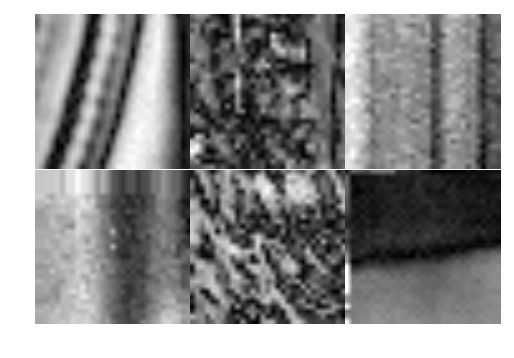

In [11]:
##################################################################################
def setParams(params):
    # Todo
    pass
##################################################################################
def cfft(tensor):
    # Perform custom forward Fourier transform from the source placeholder in complex64
    result = tf.fft2d(tensor)
    return result
    pass
##################################################################################
def cift(tensor):
    # Perform custom inverse Fourier transform from the source placeholder in complex64
    result = tf.ifft2d(tensor)
    pass
##################################################################################
def bndcrop(tensor, newshape):
    result = tensor[0:newshape[0], 
                    0:newshape[1], 
                    0:newshape[2],
                    0:newshape[3]]
    print newshape
    print tensor.get_shape()
    print result.get_shape()
    return result
    pass
##################################################################################
def zeropad(tensor, newshape):
    paddings = tuple(map(lambda src, dst: src - dst, shape, tensor.shape))
    print "padding", paddings
    result = tf.pad(tensor, 
                     [[0, paddings[0]],
                      [0, paddings[1]],
                      [0, paddings[2]],
                      [0, paddings[3]]],
                    "CONSTANT")
    return result
    pass
##################################################################################
def Pzmn(tensor):
    # Zero mean
    pass
##################################################################################
def Pnmr(tensor):
    # Normalization
    pass

##################################################################################
##################################################################################
# Implementation of Convolutional Sparse Coding Layer
class ConvSparseCodingLayer:
    # Building a single layer of Convolutional Sparse Coding Layer
    def __init__(self, S_init, D_init):
        # initialize the parameters
        self.Lambda   = 0.1
        self.Rho      = 0.001
        self.Sigma    = 0.001
        self.Jxp      = 10
        self.mu_x     = 0.01
        self.tau_x    = 2
        self.Jdp      = 10
        self.mu_d     = 0.01
        self.tau_d    = 2
        self.alpha_x  = 1.8
        self.alpha_d  = 1.8
        self.Jmax     = 100
        self.eps_abs  = 1e-6
        self.eps_rel  = 1e-6
        self.fixed_d  = False
        self.fixed_x  = False
        
        # initialize the component size
        self.elemSize = [  1,   1, 512, 512]
        self.dataSize = [  6,   1, 512, 512]
        self.dictSize = [  1,  16,  31,  31]
        self.zpadSize = [  1,  16, 512, 512]
        self.blobSize = [  1,  16, 512, 512]
        
        # initialize the component of the graph
        # Placeholder to hold the input
        self.S0 = tf.placeholder(shape=self.dataSize, dtype=tf.float32)
        self.D0 = tf.placeholder(shape=self.dataSize, dtype=tf.float32)
        
#         # Main variables
#         self.Sf = tf.Variable(tf.zeros(shape=self.dataSize, dtype=tf.complex64), name="Sf")   
#         self.Di = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Di")
#         self.Df = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Df")
#         self.Xi = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Xi")
#         self.Xf = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Xf")
        
#         # Splitting variables
#         self.Gi = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Gi") # Current
#         self.Gp = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Gp") # Previous
#         self.Gf = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Gf")
#         self.Yi = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Yi") # Current
#         self.Yp = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Yp") # Previous
#         self.Yf = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Yf")
        
#         # Dual variables
#         self.Hi = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Hi")
#         self.Hf = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Hf")
#         self.Ui = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Ui")
#         self.Uf = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Uf")
        
        pass

    ##################################################################################
    def run(self):
        """Construction"""
        # Precompute
        self.Si = tf.convert_to_tensor(S_processed.astype(np.complex64))
        self.Sf = cfft(self.Si)
        
        # Initialization
        # Main variables
        self.Sf = tf.Variable(tf.zeros(shape=self.dataSize, dtype=tf.complex64), name="Sf")   
        self.Di = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Di")
        self.Df = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Df")
        self.Xi = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Xi")
        self.Xf = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Xf")
        
        # Splitting variables
        self.Gi = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Gi") # Current
        self.Gp = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Gp") # Previous
        self.Gf = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Gf")
        self.Yi = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Yi") # Current
        self.Yp = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Yp") # Previous
        self.Yf = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Yf")
        
        # Dual variables
        self.Hi = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Hi")
        self.Hf = tf.Variable(tf.zeros(shape=self.zpadSize, dtype=tf.complex64), name="Hf")
        self.Ui = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Ui")
        self.Uf = tf.Variable(tf.zeros(shape=self.blobSize, dtype=tf.complex64), name="Uf")
        
        """Execution"""
        with tf.Session() as sess:
            # Initializing the variables
            init = tf.global_variables_initializer()
            sess.run(init)
                
            # Precompute
            np_Si = sess.run(self.Si)
            np_Sf = sess.run(self.Sf)
            # Run the iteration
            for j in range(1, self.Jmax):
                pass
        pass
    ##################################################################################
    def loss(self):
        pass
    
    ##################################################################################
    def testFourierTransform(self):
        """Construction"""
        data = tf.convert_to_tensor(S_processed.astype(np.complex64))
        freq = cfft(data)
        """Execution"""
        with tf.Session() as sess:
            # Initializing the variables
            init = sess.run(tf.global_variables_initializer())
            np_data = sess.run(data) # Return the numpy array of data
            np_freq = sess.run(freq) # Return the numpy array of frequency
            
        np_ampl = np.log(np.abs(np_freq))
        print np_ampl.shape
        plt.figure()
        for i in range(6):
            plt.subplot(2,3,i+1) # Index of subplot is +1
            plt.axis('off')
            plt.imshow(np.squeeze(np.fft.fftshift(np_ampl[i,0,:,:], axes=(0,1))))
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.01)
    ##################################################################################
    def testBoundaryCrop(self):
        """Construction"""
        source = tf.convert_to_tensor(S_processed.astype(np.complex64))
        print source.get_shape()
        #source = tf.placeholder(tf.complex64)
        result = bndcrop(source, newshape=[6, 1, 31, 31])
        """Execution"""
        with tf.Session() as sess:
            # Initializing the variables
            init = sess.run(tf.global_variables_initializer())
            np_source = sess.run(source) # Return the numpy array of data
            np_result = sess.run(result) # Return the numpy array of frequency
            
        np_result = np.abs(np_result)
        print np_result.shape
        plt.figure()
        for i in range(6):
            plt.subplot(2,3,i+1) # Index of subplot is +1
            plt.axis('off')
            plt.imshow(np.squeeze(np_result[i,0,:,:]))
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.01)
    ##################################################################################
    def testZeroPadding():
        pass


## Debug
# Construction
layer = ConvSparseCodingLayer(_, S_processed)
#layer.testFourierTransform()
layer.testBoundaryCrop()
layer.run()